In [1]:
library(ggplot2)
library(tidyr)
library(dplyr)
library(scales)
library(RColorBrewer)
library(ggtree)
library(ape)
library(cowplot)
library(grid)
library(extrafont)

Warning message:
“package ‘ggplot2’ was built under R version 3.6.2”
Warning message:
“package ‘tidyr’ was built under R version 3.6.2”
Warning message:
“package ‘dplyr’ was built under R version 3.6.2”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘scales’ was built under R version 3.6.2”
ggtree v3.1.4  For help: https://yulab-smu.top/treedata-book/

If you use ggtree in published research, please cite the most appropriate paper(s):

1. Guangchuang Yu. Using ggtree to visualize data on tree-like structures. Current Protocols in Bioinformatics, 2020, 69:e96. doi:10.1002/cpbi.96
2. Guangchuang Yu, Tommy Tsan-Yuk Lam, Huachen Zhu, Yi Guan. Two methods for mapping and visualizing associated data on phylogeny using ggtree. Molecular Biology and Evolution 2018, 35(12):3041-3043. doi:10.1093/molbev/msy194
3. Guang

In [2]:
theme_set(theme_classic() + theme(text = element_text(size=20, family = "Arial")))
options(StringsAsFactors=FALSE)
clade_colors <- c("#E64B35FF","#4DBBD5FF","#00A087FF")


# Phylogeny of L2 lineage

In [3]:
## Read in tree 
filename <- "../data/Peru_255_ML.tre"
L2tree <- ape::read.nexus(filename)
#L2tree
p <- ggtree(L2tree)

# determing clade to manipulate for visualization
edge <- data.frame(L2tree$edge, edge_num=1:nrow(L2tree$edge))
colnames(edge) <- c("parent", "node", "edge_num")


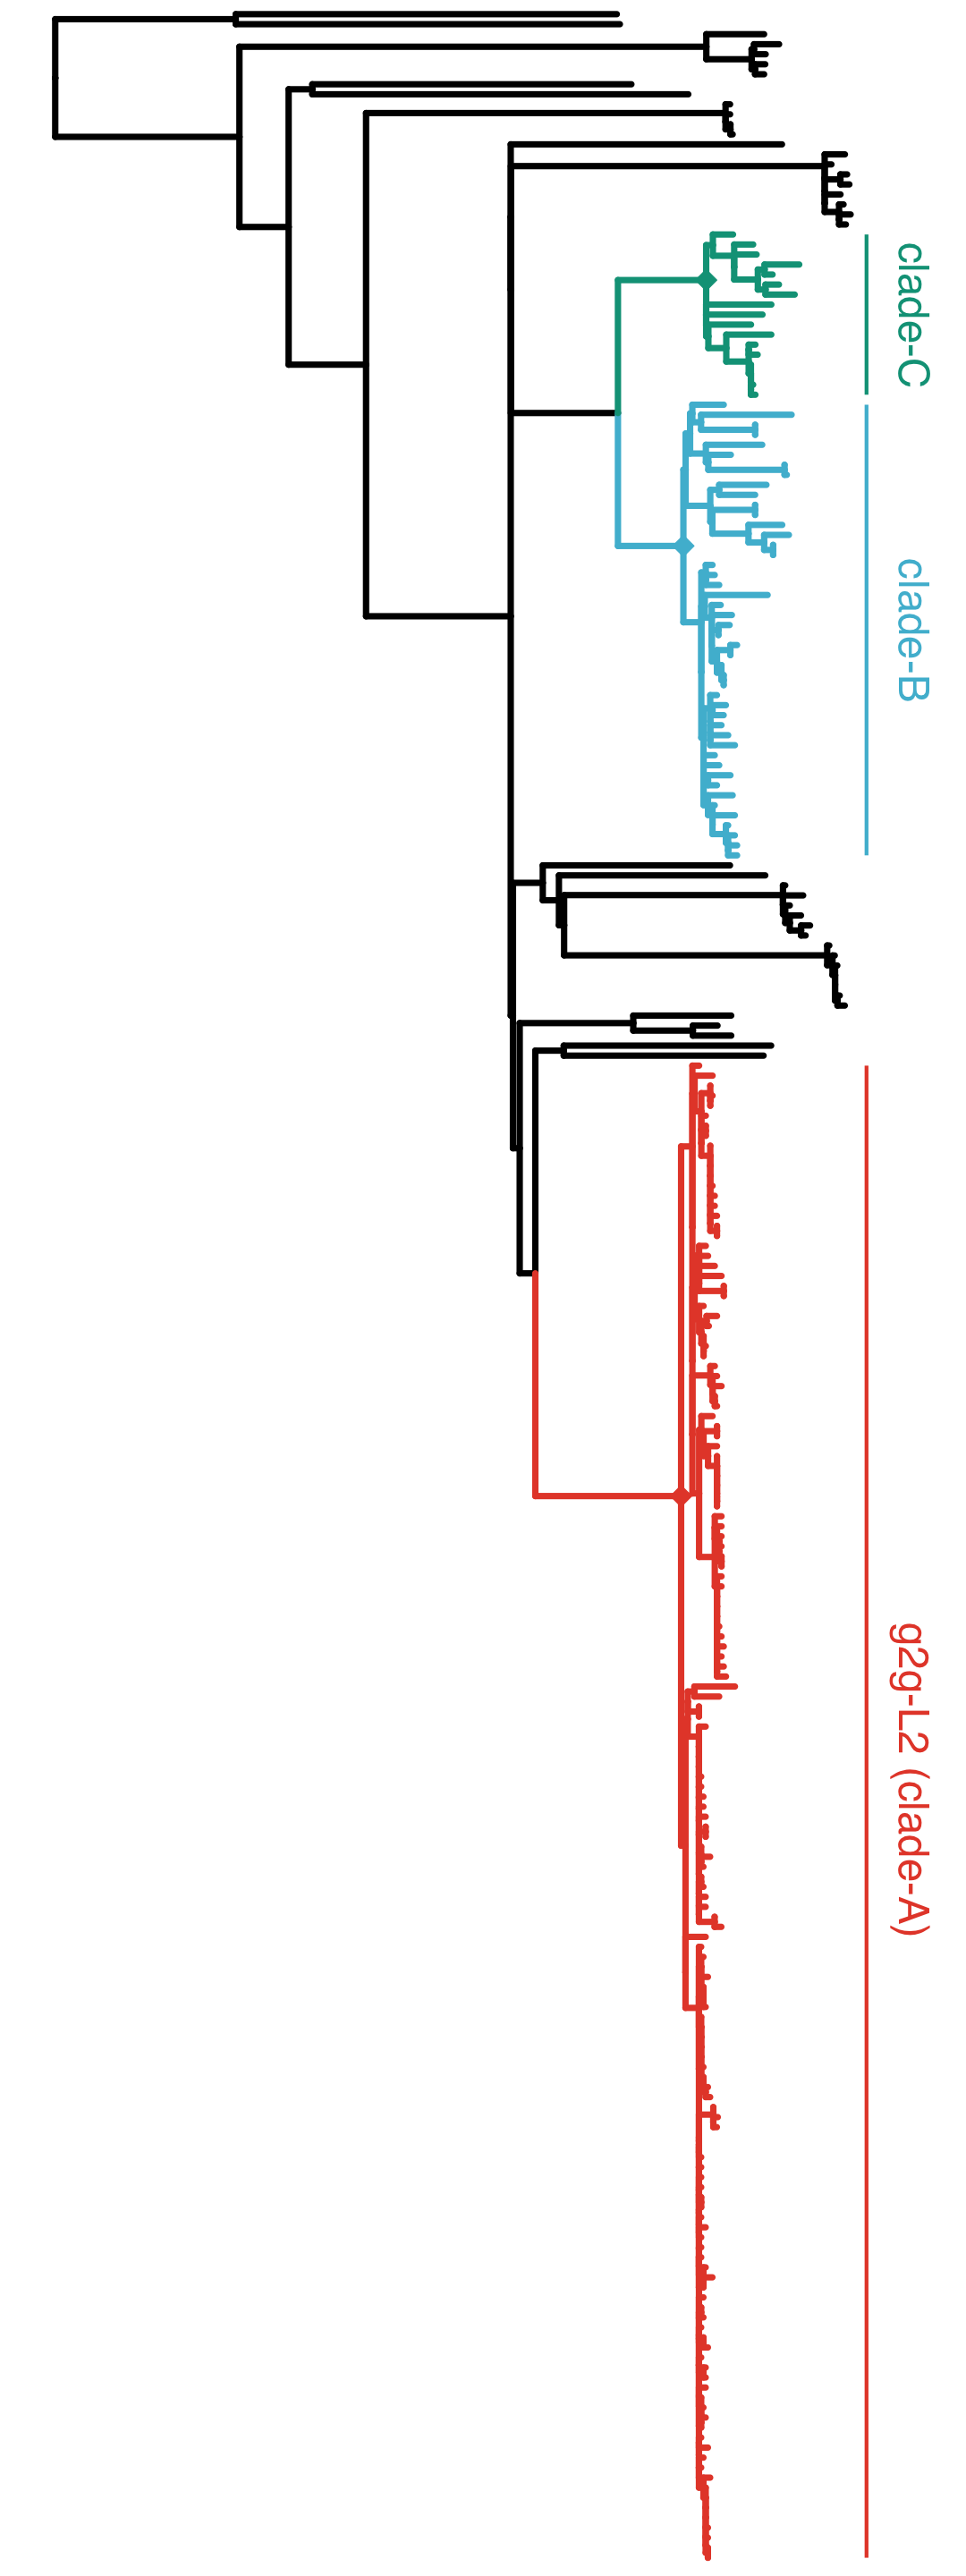

In [4]:
options(repr.plot.width=9, repr.plot.height=24)

tree2 <- groupClade(L2tree, c(361,273,318))

# Draw initial tree
p <- ggtree(tree2, aes(color=group),size=2) + 
  scale_color_manual(values=c("black", clade_colors))

pTree <- p + geom_point2(aes(subset=node %in% c(361,273,318)), fill=clade_colors[c(2,3,1)], 
                         size=5,shape=23) + theme(legend.position="none")

# flip g2g and other L2 clade
pTree <- ggtree::rotate(pTree,256)

## adding clade labels
pTree <- pTree + geom_cladelab(node=361, label="g2g-L2 (clade-A)",
                      textcolor=clade_colors[1],barcolor=clade_colors[1],
                     align=TRUE,barsize=1.2,fontsize=10,angle=270,offset.text=.005,hjust=.6) 

pTree <- pTree + geom_cladelab(node=273, label="clade-B",
                      textcolor=clade_colors[2],barcolor=clade_colors[2],
                     align=TRUE,barsize=1.2,fontsize=10,angle=270,offset.text=.005,hjust=.5) 

pTree <- pTree + geom_cladelab(node=318, label="clade-C",
                      textcolor=clade_colors[3],barcolor=clade_colors[3],
                     align=TRUE,barsize=1.2,fontsize=10,angle=270,offset.text=.005,hjust=.5) 

pTree

# Minimum SNP distance 

In [5]:
n <- length(L2tree$tip.label)

clade <- read.table("../data/L2tree_clade_info.txt",h=F,stringsAsFactors = F)

table(clade$V2)/n


l2distance <- read.table("../data/L2_min_distance.txt",h=F)
names(l2distance) <- c("sampleID","dis")

l2distance$sub <- "others"
l2distance$sub <- ifelse(l2distance$sampleID %in% clade[clade$V2=="g2g-L2",1],"Clade-A",l2distance$sub )
l2distance$sub <- ifelse(l2distance$sampleID %in% clade[clade$V2=="clade-B",1],"Clade-B",l2distance$sub )
l2distance$sub <- ifelse(l2distance$sampleID %in% clade[clade$V2=="clade-C",1],"Clade-C",l2distance$sub )
sum(table(l2distance$sub))

median(l2distance[l2distance$sub=="Clade-A","dis"])
median(l2distance[l2distance$sub=="Clade-B","dis"])
median(l2distance[l2distance$sub=="Clade-C","dis"])
x<- l2distance[l2distance$sub=="Clade-A","dis"]
y <- l2distance[l2distance$sub=="Clade-B","dis"]
ks <- ks.test(x,y,
             exact=FALSE,alternative="greater",log.p=TRUE)

(ks$p.value)


   clade-B    clade-C     g2g-L2 
0.18039216 0.06666667 0.58823529 

[1] 256

[1] 1

[1] 8

[1] 18

Warning message in ks.test(x, y, exact = FALSE, alternative = "greater", log.p = TRUE):
“p-value will be approximate in the presence of ties”


[1] 6.850239e-13

In [6]:
options(repr.plot.width=7, repr.plot.height=6)

disPlt <- ggplot(l2distance %>% filter(sub!="others"),aes(x=dis,fill=sub)) + geom_density(alpha=.5) +
ylab("Proportion of strains") + xlab("Minimum SNP distance to closest neighbors") 
disPlt <- disPlt + scale_fill_manual(values=clade_colors,name="")

grob <- grobTree(textGrob(paste("P = ",signif(ks$p.value,digits=3)), x=0.2,  y=0.9, hjust=0,
  gp=gpar(col="black", fontsize=20)))

disPlt <- disPlt + annotation_custom(grob) + 
theme(legend.position=c(0.7,.6),
                           legend.text = element_text(size=20),
     text = element_text(size=20))

#ggsave("../figures//Fig4B_min_SNP.pdf",width=6,height=6)

# L2 transmission cluster rate

In [7]:
l2cluster <- read.table("../data/L2_cluster_rate.txt",h=T,stringsAsFactors = F)

In [8]:
pcluster <- l2cluster %>% filter(group!="others") %>%
  mutate(type = factor(type, levels=c("6-SNP", "12-SNP"))) %>%
ggplot(aes(y=rate,x=type,fill=group)) + 
geom_bar(stat = "identity", position=position_dodge())

pcluster <- pcluster + scale_fill_manual(values=clade_colors,name="Clade")+ 
ylab("Cluster rate") +xlab("") + theme(legend.position="none",
                                      text = element_text(size=20))

# Combine plot (B,C only)

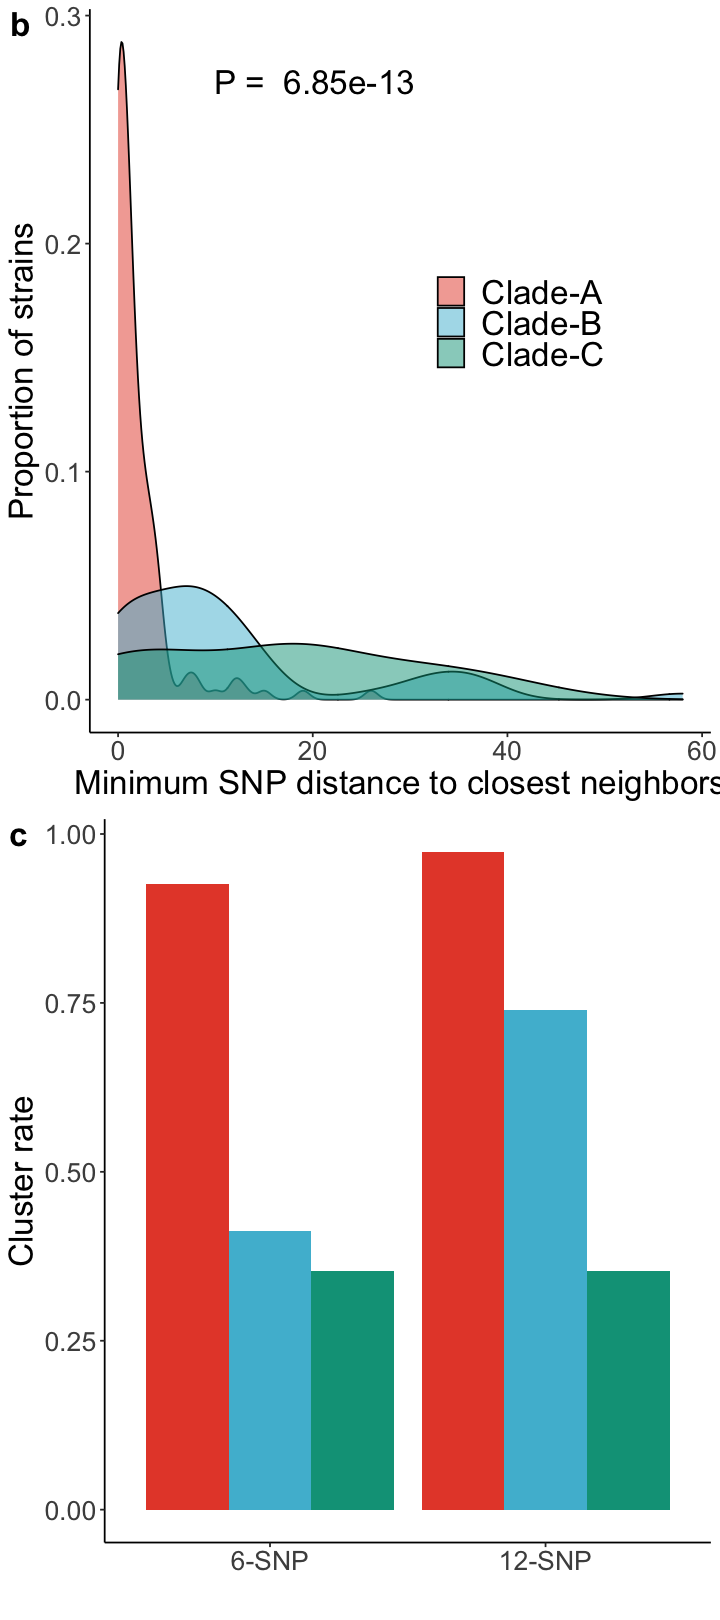

In [11]:
options(repr.plot.width = 6, repr.plot.height = 13.5)


ggdraw() +
  draw_plot(disPlt, x = 0, y = .5, width = 1, height = .5) +
  draw_plot(pcluster, x = 0, y = 0, width = 1, height = .5) +
  draw_plot_label(label = c("b", "c"), size = 20,font="bold",
                  x = c(0, 0), y = c(1,.5))



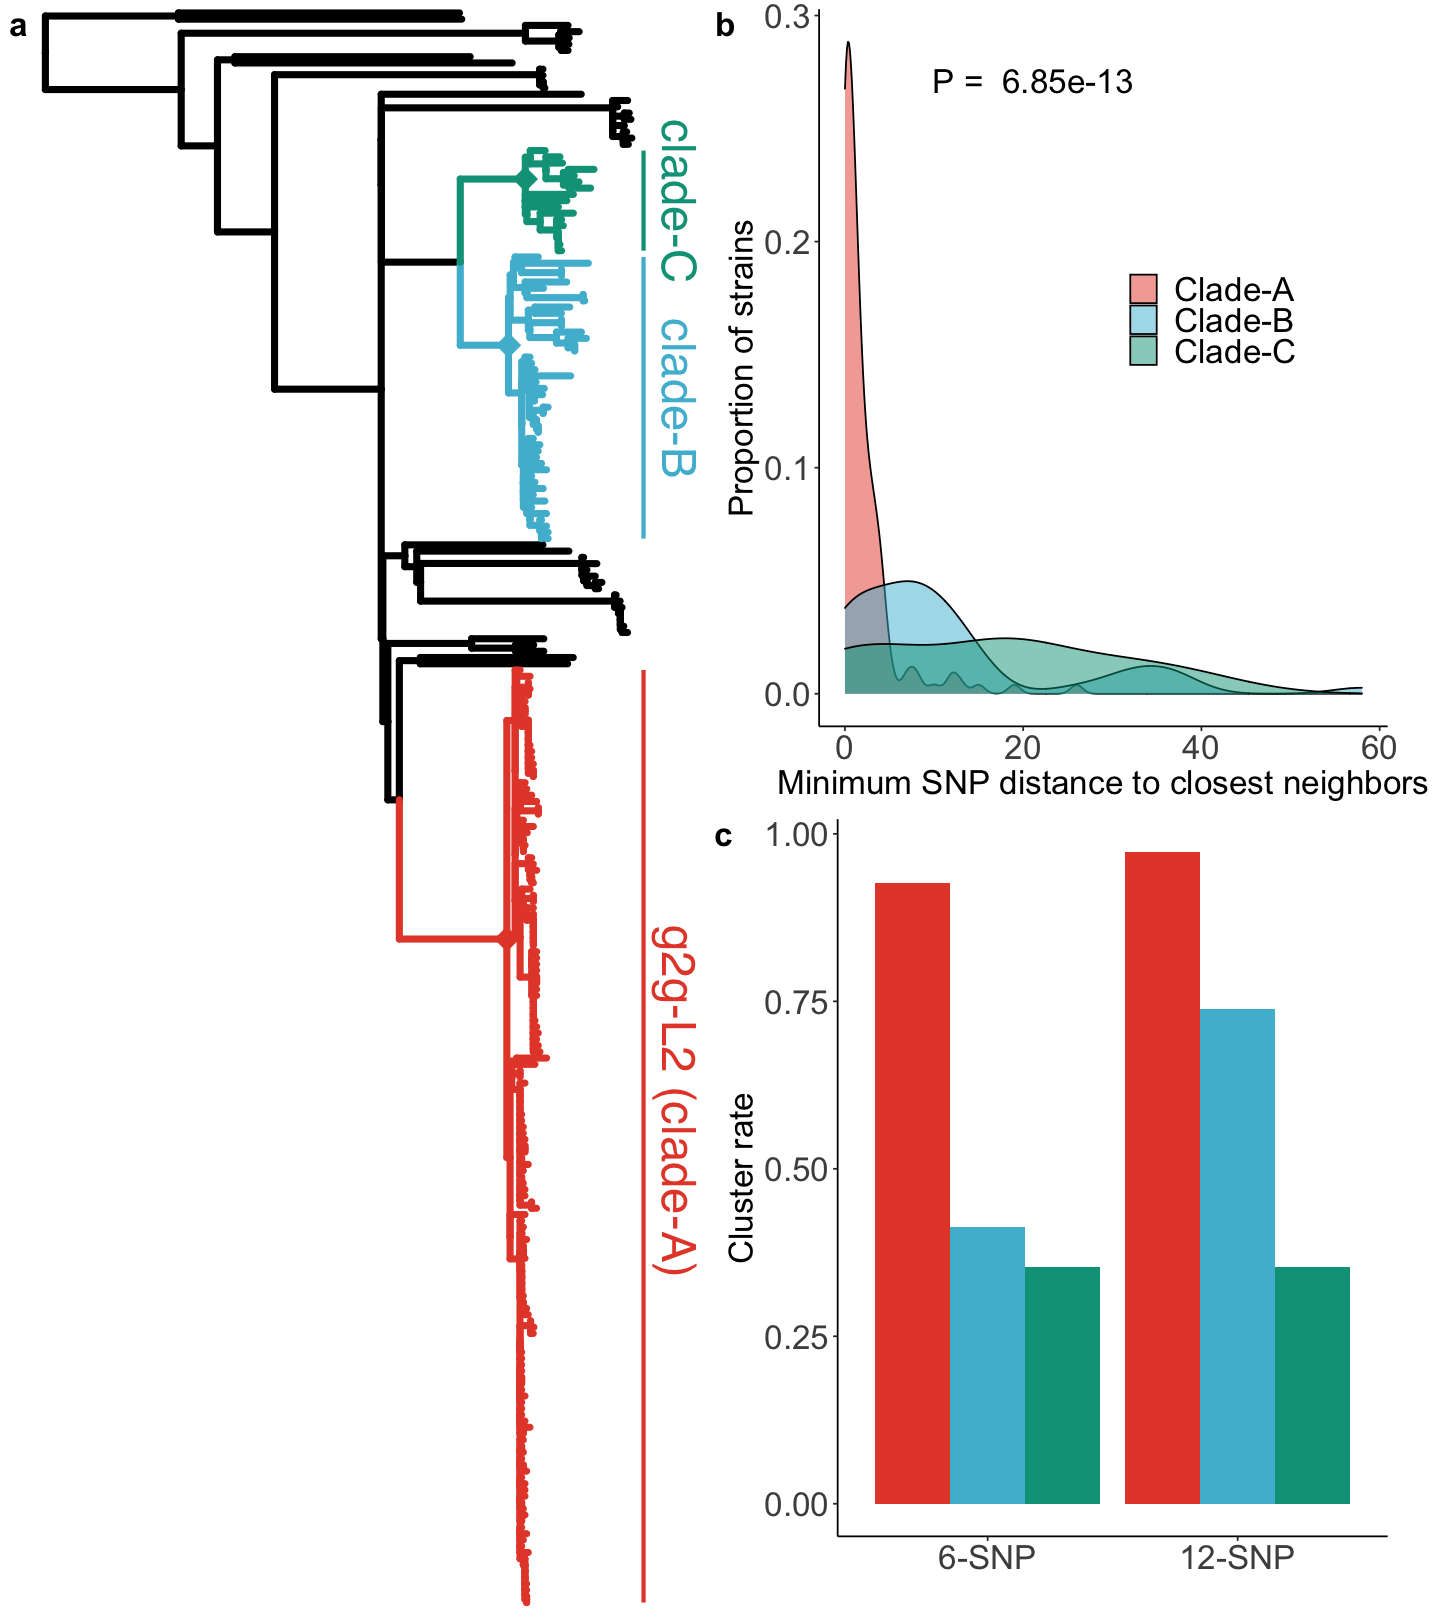

In [13]:
options(repr.plot.width = 12, repr.plot.height = 13.5)


ggdraw() +
  draw_plot(pTree  , x=0, y=0,width=.5,height=1) +
  draw_plot(disPlt +theme(axis.text=element_text(size=20)) , x = 0.5, y = .5, width = .47, height = .5) +
  draw_plot(pcluster+theme(axis.text=element_text(size=20)), x = 0.5, y = 0, width = .47, height = .5) +
  draw_plot_label(label = c("a","b", "c"), size = 20,font="bold",family="Arial",
                  x = c(0, 0.49,0.49), y = c(1,1,.5))

ggsave("../figures/Fig4_L2.pdf",height=13.5,width=12)